In [3]:
# Import required dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
import pipeline_utilities as p_utils
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from prophet import Prophet
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Exploration

In [4]:
# Import data file
file_path = r"C:\Users\sebas\OneDrive\Desktop\_CU-VIRT-AI-PT-03-2024-U-LOLC\ClassProject\project2\Summer.csv"
df = pd.read_csv(file_path)
# Display the first few rows of the dataframe
print(df.head(20))

    Year    City      Sport Discipline                Athlete Country Gender  \
0   1896  Athens   Aquatics   Swimming          HAJOS, Alfred     HUN    Men   
1   1896  Athens   Aquatics   Swimming       HERSCHMANN, Otto     AUT    Men   
2   1896  Athens   Aquatics   Swimming      DRIVAS, Dimitrios     GRE    Men   
3   1896  Athens   Aquatics   Swimming     MALOKINIS, Ioannis     GRE    Men   
4   1896  Athens   Aquatics   Swimming     CHASAPIS, Spiridon     GRE    Men   
5   1896  Athens   Aquatics   Swimming  CHOROPHAS, Efstathios     GRE    Men   
6   1896  Athens   Aquatics   Swimming          HAJOS, Alfred     HUN    Men   
7   1896  Athens   Aquatics   Swimming       ANDREOU, Joannis     GRE    Men   
8   1896  Athens   Aquatics   Swimming  CHOROPHAS, Efstathios     GRE    Men   
9   1896  Athens   Aquatics   Swimming          NEUMANN, Paul     AUT    Men   
10  1896  Athens   Aquatics   Swimming      PEPANOS, Antonios     GRE    Men   
11  1896  Athens  Athletics  Athletics  

In [5]:
#Get info on all features and target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31165 entries, 0 to 31164
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        31165 non-null  int64 
 1   City        31165 non-null  object
 2   Sport       31165 non-null  object
 3   Discipline  31165 non-null  object
 4   Athlete     31165 non-null  object
 5   Country     31161 non-null  object
 6   Gender      31165 non-null  object
 7   Event       31165 non-null  object
 8   Medal       31165 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.1+ MB


In [6]:
#get medal count by country - top 5
top_five = df.groupby('Country').agg(Medal_count=('Medal','count')).sort_values('Medal_count', ascending=False).reset_index()
top_five.head()

,Country,Medal_count
0,USA,4585
1,URS,2049
2,GBR,1720
3,FRA,1396
4,GER,1305


In [7]:
#get medal count by year, country 
medal_ct_country = df.groupby(['Year','Country']).agg(Medal_count=('Medal','count')).sort_values('Medal_count', ascending=False).reset_index()
medal_ct_country.head()

,Year,Country,Medal_count
0,1980,URS,442
1,1904,USA,394
2,1908,GBR,347
3,1984,USA,333
4,2008,USA,315


In [67]:
#get medal count by year, country, medal groupings
medal_type_ct_country = df.groupby(['Year','Country','Medal']).agg(Medal_count=('Medal','count')).sort_values('Medal_count', ascending=False).reset_index()
medal_type_ct_country.head()

,Year,Country,Medal,Medal_count
0,1980,URS,Gold,192
1,1984,USA,Gold,168
2,1996,USA,Gold,160
3,2012,USA,Gold,147
4,1904,USA,Gold,146


In [9]:
#select USA and set year as index
usa_metal_type_df = medal_type_ct_country.loc[medal_type_ct_country['Country']=='USA'].sort_values(by=['Year'])
usa_metal_type_df.set_index('Year',inplace=True)
usa_metal_type_df.head()


,Country,Medal,Medal_count
Year,,,
1896,USA,Bronze,2
1896,USA,Silver,7
1896,USA,Gold,11
1900,USA,Silver,14
1900,USA,Bronze,14


In [10]:
#select USA and set year as index
usa_df = medal_ct_country.loc[medal_ct_country['Country']=='USA'].sort_values(by=['Year'])
usa_df.set_index('Year',inplace=True)
usa_df.head()


,Country,Medal_count
Year,,
1896,USA,20
1900,USA,55
1904,USA,394
1908,USA,63
1912,USA,101


<Axes: title={'center': 'USA Medal Count from 1896 to 2012'}, xlabel='Year'>

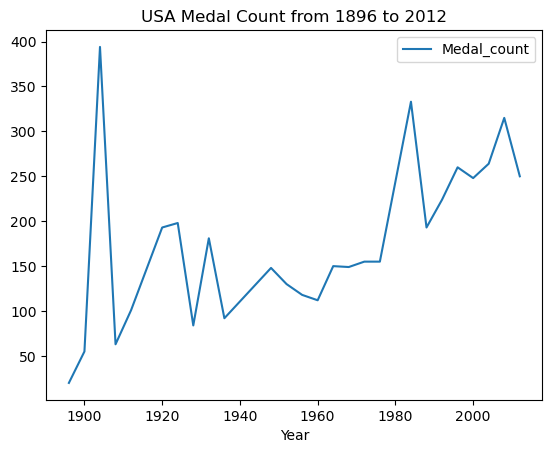

In [11]:
#plot the dataframe
usa_df.plot(title='USA Medal Count from 1896 to 2012')

<Axes: title={'center': 'USA Medal Count from 1896 to 2012'}, xlabel='Year', ylabel='Medal_count'>

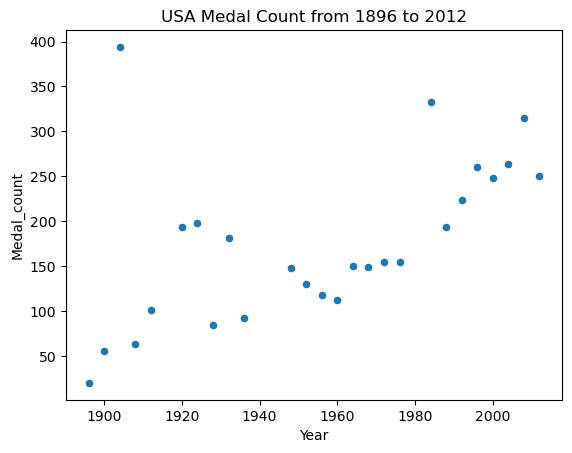

In [12]:
# Create a scatter plot for USA medal counts over the years
usa_df.reset_index(inplace=True)
usa_plot = usa_df.plot.scatter(
    x='Year',
    y='Medal_count',
    title='USA Medal Count from 1896 to 2012'
)
usa_plot

In [13]:
# Use the corr function to compute the correlation between year and medal count
usa_corr = usa_df[['Year','Medal_count']].corr()
usa_corr

,Year,Medal_count
Year,1.000000,0.529927
Medal_count,0.529927,1.000000


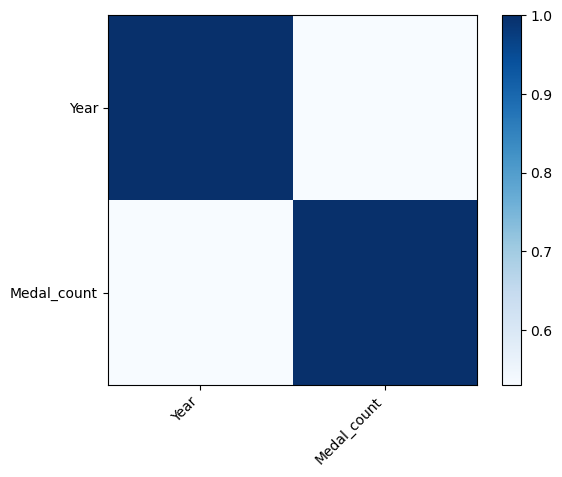

In [14]:
import matplotlib.pyplot as plt
plt.imshow(usa_corr, cmap='Blues')
plt.colorbar()
variables = ['Year','Medal_count']
plt.xticks(range(len(variables)), variables, rotation=45, ha='right')
plt.yticks(range(len(variables)), variables)
plt.show()

In [15]:
# Use pandas to find potential outliers by calculating the interquartile range (IQR)
medal_ct =usa_df['Medal_count']

Q1 = medal_ct.quantile(0.25)
median = medal_ct.quantile(0.5)
Q3 = medal_ct.quantile(0.75)
IQR = Q3 - Q1

print(f"The lower quartile of medal count is: {Q1}")
print(f"The upper quartile of medal count is: {Q3}")
print(f"The interquartile range of medal count is: {IQR}")
print(f"The the median of medal count is: {median} ")

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")


The lower quartile of medal count is: 113.5
The upper quartile of medal count is: 242.0
The interquartile range of medal count is: 128.5
The the median of medal count is: 155.0 
Values below -79.25 could be outliers.
Values above 434.75 could be outliers.


In [16]:
# remove data outliers based on historical events 
# removing years 1904(Russian/Japanese war & first time Olympics hosted outside of Europe) and 1984 (most communist countries boycotted the Olympics)
usa_trimmed_df = usa_df.drop([2,18])
usa_trimmed_df.head()

,Year,Country,Medal_count
0,1896,USA,20
1,1900,USA,55
3,1908,USA,63
4,1912,USA,101
5,1920,USA,193


<Axes: title={'center': 'USA Medal Count from 1896 to 2012 w/o Outliers'}, xlabel='Year', ylabel='Medal_count'>

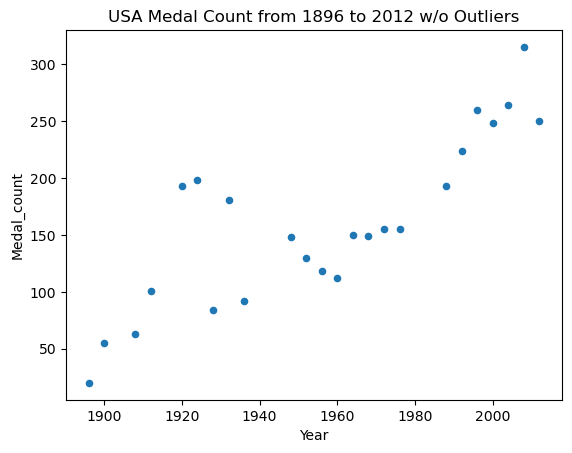

In [17]:
# Create a scatter plot for USA medal counts over the years for new dataframe without outlier years
usa_plot = usa_trimmed_df.plot.scatter(
    x='Year',
    y='Medal_count',
    title='USA Medal Count from 1896 to 2012 w/o Outliers'
)
usa_plot

In [18]:
# Use the corr function to compute the correlation between year and medal count
usa_corr_trimmed = usa_trimmed_df[['Year','Medal_count']].corr()
usa_corr

,Year,Medal_count
Year,1.000000,0.529927
Medal_count,0.529927,1.000000


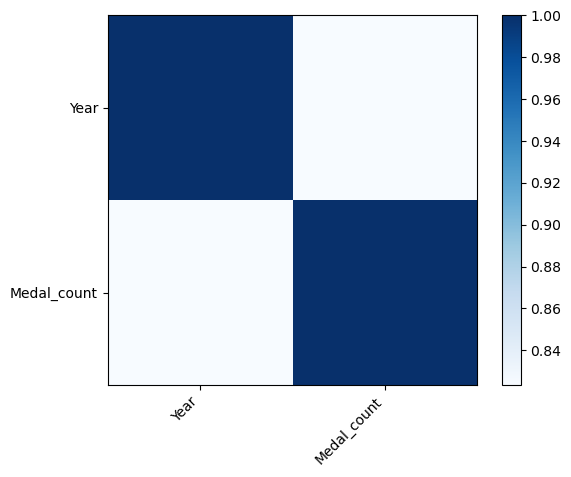

In [19]:
plt.imshow(usa_corr_trimmed, cmap='Blues')
plt.colorbar()
variables = ['Year','Medal_count']
plt.xticks(range(len(variables)), variables, rotation=45, ha='right')
plt.yticks(range(len(variables)), variables)
plt.show()


# Time Series Forecasting Projections Using Prophet

In [20]:
#drop the country column
prophet_df = usa_trimmed_df.drop('Country', axis=1)

In [21]:
#convert year to datetime
prophet_df['Year'] = pd.to_datetime(prophet_df['Year'], format='%Y')

In [22]:
# Prepare the training data to be read into a prophet model
# Rename the columns to names that Prophet recognizes
prophet_df.columns = ['ds', 'y']
prophet_df.head()


,ds,y
0,1896-01-01,20
1,1900-01-01,55
3,1908-01-01,63
4,1912-01-01,101
5,1920-01-01,193


In [23]:
# Confirm that there are no NaN values
prophet_df = prophet_df.dropna()
prophet_df.tail()

,ds,y
21,1996-01-01,260
22,2000-01-01,248
23,2004-01-01,264
24,2008-01-01,315
25,2012-01-01,250


In [24]:
prophet_df.shape

(24, 2)

In [25]:
# Call the Prophet function and store as an object
m = Prophet()

In [26]:
# Fit the time series Prophet model
m.fit(prophet_df)

08:59:15 - cmdstanpy - INFO - Chain [1] start processing
08:59:16 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Create a future DataFrame to hold predictions
future = m.make_future_dataframe(periods=13,freq='Y')


# Review the first and last 10 rows of the DataFrame
future.tail(13)

C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


,ds
24,2012-12-31
25,2013-12-31
26,2014-12-31
27,2015-12-31
28,2016-12-31
29,2017-12-31
30,2018-12-31
31,2019-12-31
32,2020-12-31
33,2021-12-31


In [28]:
future.drop(index=[24,25,26,27,29,30,31,33,34,35],inplace=True)
future.reset_index(inplace=True)
future.tail()

,index,ds
22,22,2008-01-01
23,23,2012-01-01
24,28,2016-12-31
25,32,2020-12-31
26,36,2024-12-31


In [29]:
# Make a forecast based on the future DataFrame
forecast = m.predict(future)

# Review the first five rows of the forecast DataFrame
display(forecast.head())
display(forecast.tail())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1896-01-01,1.269428,-14.457994,84.529708,1.269428,1.269428,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,34.403518
1,1900-01-01,7.529299,-7.864923,95.344063,7.529299,7.529299,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,40.663389
2,1908-01-01,20.044757,37.884811,140.625397,20.044757,20.044757,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,88.009578
3,1912-01-01,26.304628,41.555345,144.417967,26.304628,26.304628,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,94.269449
4,1920-01-01,38.824370,55.621114,161.055057,38.824370,38.824370,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,106.789191


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2008-01-01,176.541831,192.131294,293.597848,176.541831,176.541831,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,244.506651
23,2012-01-01,182.801726,201.826871,300.491426,182.801726,182.801726,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,250.766547
24,2016-12-31,190.625524,215.307768,320.918389,190.625523,190.625524,76.556113,76.556113,76.556113,76.556113,76.556113,76.556113,0.0,0.0,0.0,267.181637
25,2020-12-31,196.885419,223.146190,327.928996,196.885416,196.885421,76.556113,76.556113,76.556113,76.556113,76.556113,76.556113,0.0,0.0,0.0,273.441532
26,2024-12-31,203.145314,227.572698,333.305042,203.145309,203.145319,76.556113,76.556113,76.556113,76.556113,76.556113,76.556113,0.0,0.0,0.0,279.701427


C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


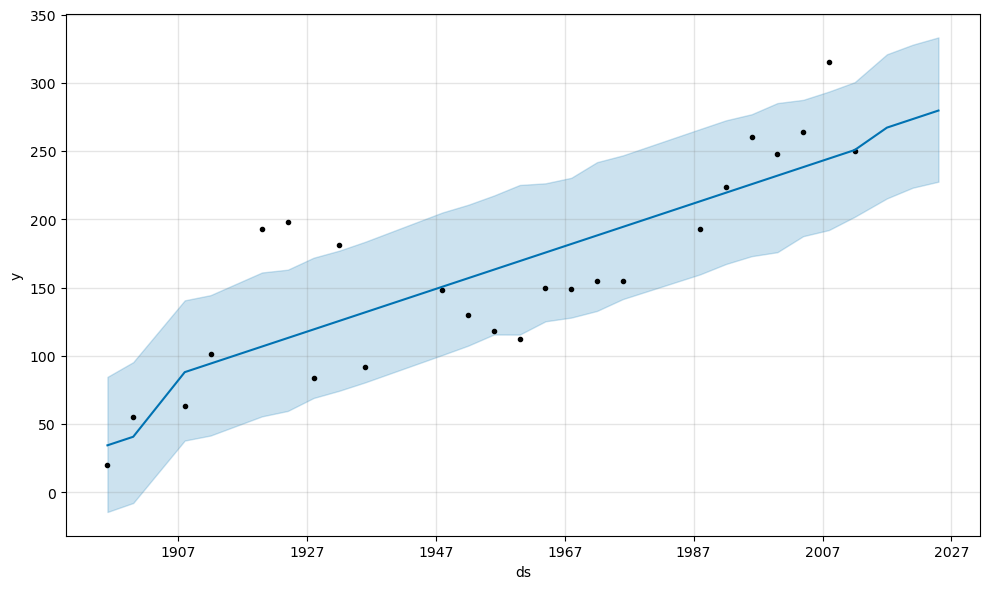

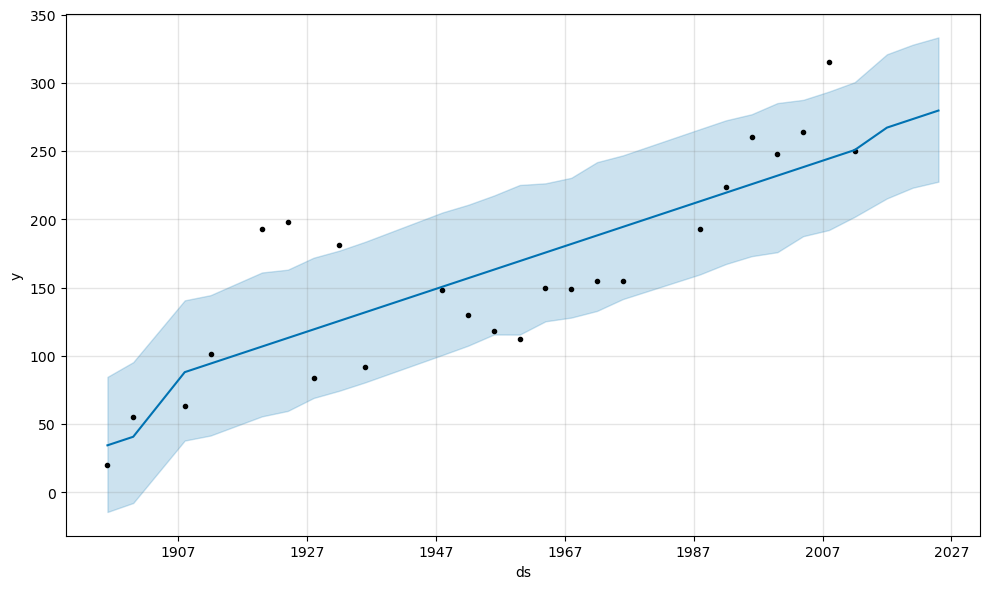

In [30]:
# Plot the forecast using the model’s plot function
m.plot(forecast)

In [31]:
#Plot the Upper and Lower Bounds of the Forecast
# Reset the index to this datetime column so that our plot looks nice
forecast = forecast.set_index('ds')

# Display the DataFrame
forecast.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
1896-01-01,1.269428,-14.457994,84.529708,1.269428,1.269428,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,34.403518
1900-01-01,7.529299,-7.864923,95.344063,7.529299,7.529299,33.134090,33.134090,33.134090,33.134090,33.134090,33.134090,0.0,0.0,0.0,40.663389
1908-01-01,20.044757,37.884811,140.625397,20.044757,20.044757,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,88.009578
1912-01-01,26.304628,41.555345,144.417967,26.304628,26.304628,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,94.269449
1920-01-01,38.824370,55.621114,161.055057,38.824370,38.824370,67.964821,67.964821,67.964821,67.964821,67.964821,67.964821,0.0,0.0,0.0,106.789191


<Axes: xlabel='ds'>

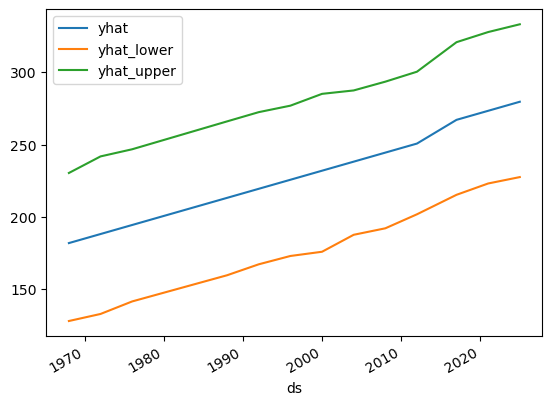

In [32]:
# Plot predictions for our forecast period
forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-13:,:].plot()

C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

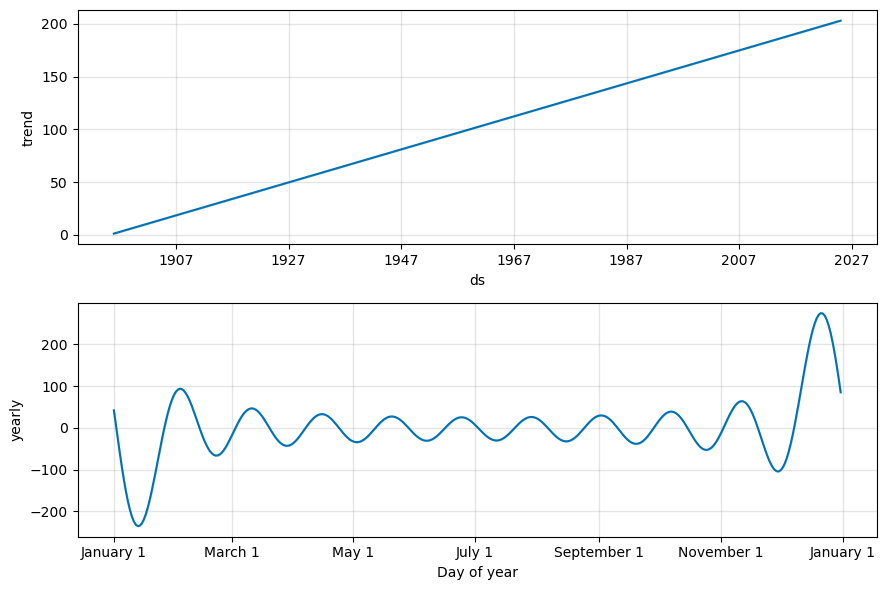

In [33]:
# Reset "ds" from the datetime index back to a column
forecast = forecast.reset_index()

# Plot the individual time series components of the model
fig2 = m.plot_components(forecast)

In [34]:
# Perform cross-validation
df_cv = cross_validation(m, initial='14600 days',period='1460 days',horizon='2920 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

  0%|          | 0/15 [00:00<?, ?it/s]

08:59:38 - cmdstanpy - INFO - Chain [1] start processing
08:59:38 - cmdstanpy - INFO - Chain [1] done processing
08:59:38 - cmdstanpy - INFO - Chain [1] start processing
08:59:39 - cmdstanpy - INFO - Chain [1] done processing
08:59:39 - cmdstanpy - INFO - Chain [1] start processing
08:59:39 - cmdstanpy - INFO - Chain [1] done processing
08:59:39 - cmdstanpy - INFO - Chain [1] start processing
08:59:39 - cmdstanpy - INFO - Chain [1] done processing
08:59:39 - cmdstanpy - INFO - Chain [1] start processing
08:59:39 - cmdstanpy - INFO - Chain [1] done processing
08:59:39 - cmdstanpy - INFO - Chain [1] start processing
08:59:39 - cmdstanpy - INFO - Chain [1] done processing
08:59:40 - cmdstanpy - INFO - Chain [1] start processing
08:59:40 - cmdstanpy - INFO - Chain [1] done processing
08:59:40 - cmdstanpy - INFO - Chain [1] start processing
08:59:40 - cmdstanpy - INFO - Chain [1] done processing
08:59:40 - cmdstanpy - INFO - Chain [1] start processing
08:59:40 - cmdstanpy - INFO - Chain [1]

Mean Absolute Error: 40.59
Mean Squared Error: 2291.68
Root Mean Squared Error: 47.87


# Evaluate p-values for Regression Models

In [35]:
df.head()

,Year,City,Sport,Discipline,Athlete,Country,Gender,Event,Medal
0,1896,Athens,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100M Freestyle,Gold
1,1896,Athens,Aquatics,Swimming,"HERSCHMANN, Otto",AUT,Men,100M Freestyle,Silver
2,1896,Athens,Aquatics,Swimming,"DRIVAS, Dimitrios",GRE,Men,100M Freestyle For Sailors,Bronze
3,1896,Athens,Aquatics,Swimming,"MALOKINIS, Ioannis",GRE,Men,100M Freestyle For Sailors,Gold
4,1896,Athens,Aquatics,Swimming,"CHASAPIS, Spiridon",GRE,Men,100M Freestyle For Sailors,Silver


In [36]:
#isolate USA data 

#usa_df = df[(df['Country'] == 'RUS') | (df['Country'] == 'URS')]
usa_df = df[df['Country'] == 'USA']

In [37]:
d = {'nunique':['Sport','Discipline','Athlete','Gender','Event'],'count':['Medal']}
usa_grouped_df = usa_df.groupby(['Year']).agg({k: v for v,l in d.items() for k in l})
usa_grouped_df.reset_index(inplace=True)
usa_grouped_df.head(10)

,Year,Sport,Discipline,Athlete,Gender,Event,Medal
0,1896,2,2,12,1,12,20
1,1900,6,6,37,2,24,55
2,1904,16,17,270,2,89,394
3,1908,6,7,51,1,32,63
4,1912,5,5,69,1,39,101
5,1920,11,12,133,2,62,193
6,1924,11,13,172,2,59,198
7,1928,6,7,73,2,33,84
8,1932,12,16,161,2,61,181
9,1936,10,11,82,2,34,92


In [38]:
# get list of Year in descending order for ordinal encoder
years = usa_grouped_df['Year'].sort_values().unique()

In [39]:
# Create an encoder for the categorical ordinal column for 
year_ord_enc = OrdinalEncoder(categories=[years],
                                            encoded_missing_value=-1, 
                                            handle_unknown='use_encoded_value', 
                                            unknown_value=-1)
# Set up the OneHotEncoder so it will transform to Pandas
year_ord_enc.set_output(transform="pandas")


# Fit and transform the OneHotEncoder to the columns to encode
year_ord_enc = year_ord_enc.fit_transform(usa_grouped_df[['Year']])
year_ord_enc.head()

,Year
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0


In [40]:
#concat above dataframes
df_enc = pd.concat([usa_grouped_df,year_ord_enc],axis=1)
df_enc = df_enc.iloc[:,1:]
df_enc.head()

,Sport,Discipline,Athlete,Gender,Event,Medal,Year
0,2,2,12,1,12,20,0.0
1,6,6,37,2,24,55,1.0
2,16,17,270,2,89,394,2.0
3,6,7,51,1,32,63,3.0
4,5,5,69,1,39,101,4.0


In [41]:
#get the features
X = df_enc.drop(columns=['Medal'])
X.head()

,Sport,Discipline,Athlete,Gender,Event,Year
0,2,2,12,1,12,0.0
1,6,6,37,2,24,1.0
2,16,17,270,2,89,2.0
3,6,7,51,1,32,3.0
4,5,5,69,1,39,4.0


In [42]:
#get target column
y=usa_grouped_df['Medal'].values.reshape(-1,1)

In [43]:
#train-test-split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
import statsmodels.api as sm

# Use the statsmodels package to create and fit a linear regression
lr = sm.OLS(y_train, X_train).fit()

In [47]:
# Show the p-values of all columns sorted in descending order
lr.pvalues.sort_values(ascending=True)

Athlete       0.000046
Discipline    0.161015
Sport         0.231468
Event         0.352957
Gender        0.485008
Year          0.739321
dtype: float64

In [48]:
#get the features - Remove Ordinal Encoder for Year
X = usa_grouped_df.drop(columns=['Medal'])
X.head()

,Year,Sport,Discipline,Athlete,Gender,Event
0,1896,2,2,12,1,12
1,1900,6,6,37,2,24
2,1904,16,17,270,2,89
3,1908,6,7,51,1,32
4,1912,5,5,69,1,39


In [49]:
#get target column
y=usa_grouped_df['Medal'].values.reshape(-1,1)

#train-test-split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
# Use the statsmodels package to create and fit a linear regression
lr = sm.OLS(y_train, X_train).fit()

# Show the p-values of all columns sorted in ascending order
lr.pvalues.sort_values(ascending=True)

Athlete       0.000018
Discipline    0.018035
Sport         0.145625
Event         0.420766
Gender        0.642894
Year          0.959500
dtype: float64

<Axes: xlabel='Year', ylabel='Athlete'>

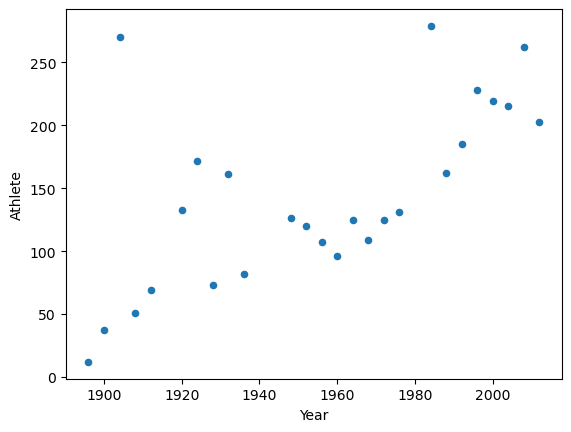

In [51]:
# Create a scatter plot for # of Atheletes vs Year
athlete_plot = usa_grouped_df.plot.scatter(
    x='Year',
    y='Athlete'
)
athlete_plot

# Use Model Generator Pipeline to Evaluate Three Models

In [52]:
#drop unnecessary columns based on p-values: Event, Gender, Year
# Event, Sport, Discipline, Athelete
clean_df = p_utils.drop_columns(usa_grouped_df)
clean_df.head()

,Sport,Discipline,Athlete,Medal
0,2,2,12,20
1,6,6,37,55
2,16,17,270,394
3,6,7,51,63
4,5,5,69,101


In [53]:
#run model generator function from python file
pipeline = p_utils.medal_model_generator(clean_df)
pipeline

Testing Linear Regression
Mean Squared Error: 647.7073257711792
R-squared: 0.9538576096031116
Adjusted R-squared: 0.9077152192062232
------------------------------------------
Testing Random Forest Regressor
Mean Squared Error: 3306.342814285713
R-squared: 0.7644575646244658
Adjusted R-squared: 0.5289151292489316
------------------------------------------
Testing XGB Regressor
Mean Squared Error: 2256.866256724444
R-squared: 0.8392218217273447
Adjusted R-squared: 0.6784436434546894
------------------------------------------


C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Testing SVR Regressor
Mean Squared Error: 16705.16988227389
R-squared: -0.19006909399467986
Adjusted R-squared: -1.3801381879893597
------------------------------------------
Linear Regression is the best model.


C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('Linear Regression', LinearRegression())])

# 2016 - 2024 Predictions
## explore data to fill in feature values for future predictions

The most common number of Athletes participating in the Olympic is 125 while the average number of athletes participating in the Olympics is 144.0.


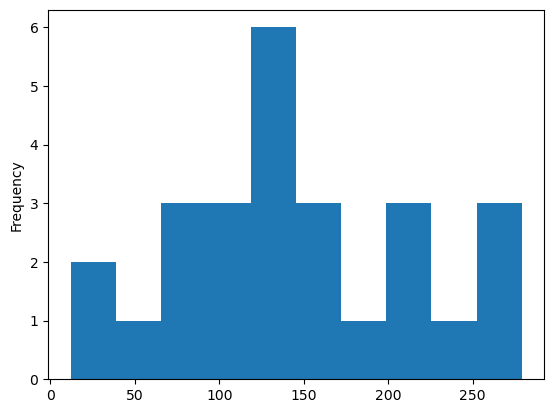

In [54]:
#create histogram by Athlete
clean_df['Athlete'].plot.hist()
mode = clean_df['Athlete'].mode()[0]
mean = clean_df.mean()['Athlete'].round()
print(f'The most common number of Athletes participating in the Olympic is {mode} while the average number of athletes participating in the Olympics is {mean}.')

<Axes: xlabel='Year', ylabel='Athlete'>

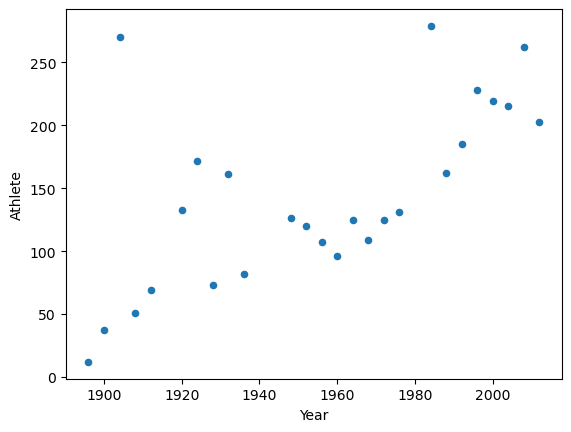

In [55]:
# Create a scatter plot for # of Atheletes vs Year
athlete_plot = usa_grouped_df.plot.scatter(
    x='Year',
    y='Athlete'
)
athlete_plot

The most common number of Sports the USA participates in the Olympic is 11 while the average number of sports in the Olympics is 12.0.


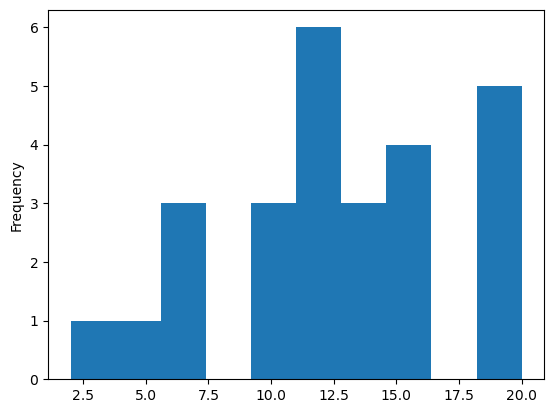

In [56]:
#create histogram by Sport
clean_df['Sport'].plot.hist()
mode = clean_df['Sport'].mode()[0]
mean = clean_df.mean()['Sport'].round()
print(f'The most common number of Sports the USA participates in the Olympic is {mode} while the average number of sports in the Olympics is {mean}.')

<Axes: xlabel='Year', ylabel='Sport'>

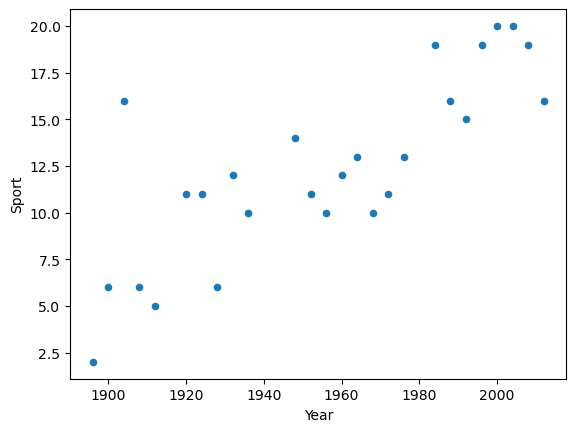

In [57]:
# Create a scatter plot for # of Atheletes vs Year
athlete_plot = usa_grouped_df.plot.scatter(
    x='Year',
    y='Sport'
)
athlete_plot

The most common number of disciplines the USA participates in the Olympic is 25 while the average number of disciplines in the Olympics is 15.0.


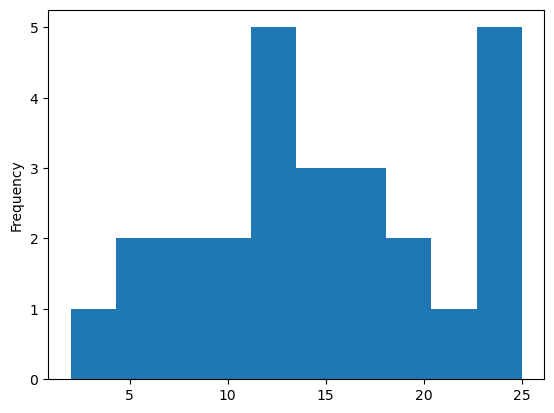

In [58]:
#create histogram by Discipline
clean_df['Discipline'].plot.hist()
mode = clean_df['Discipline'].mode()[0]
mean = clean_df.mean()['Discipline'].round()
print(f'The most common number of disciplines the USA participates in the Olympic is {mode} while the average number of disciplines in the Olympics is {mean}.')

<Axes: xlabel='Year', ylabel='Discipline'>

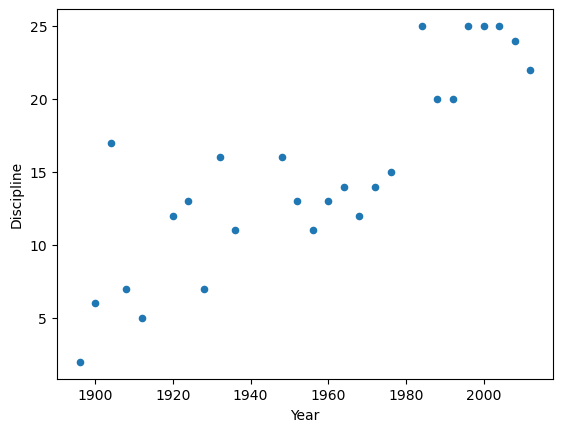

In [59]:
# Create a scatter plot for # of Disciplines vs Year
athlete_plot = usa_grouped_df.plot.scatter(
    x='Year',
    y='Discipline'
)
athlete_plot

In [60]:
#create 2020 - 2024 rows and add to dataframe to get predictions using model 
X = pd.DataFrame({'Sport':[15,17,18],
            'Discipline':[24,23,25],
            'Athlete':[144,138,146]})
X

,Sport,Discipline,Athlete
0,15,24,144
1,17,23,138
2,18,25,146


In [61]:
# #create 2020 - 2024 rows and add to dataframe to get predictions using model 
# X = pd.DataFrame({'Sport':[18,18,18],
#             'Discipline':[27,44,42],
#             'Athlete':[210,257,250]})

In [62]:
# get predictions from test dataset by implementing winning model
y_pred = pipeline.predict(X)

In [63]:
# add actual medal count values for 2016 and 2020 Olympics
Actual_Medal_Ct = pd.DataFrame({'Year':[2016,2020,2024],
            'Actual_Medal_Ct':[121,113,125]})

In [64]:
#display predictions vs actuals in a dataframe
#y_actual_df = pd.DataFrame(y_test).rename(columns={0:'Medal_Ct'})
y_pred_df = pd.DataFrame(y_pred).rename(columns={0:'Predicted_Medal_Ct'}).round()

actual_predictions_df = pd.concat([X,y_pred_df,Actual_Medal_Ct],axis=1)
actual_predictions_df
actual_predictions_df['Prediction vs Actual'] = actual_predictions_df['Predicted_Medal_Ct'] - actual_predictions_df['Actual_Medal_Ct']
actual_predictions_df = actual_predictions_df.reindex(columns=['Year','Sport','Discipline','Athlete','Predicted_Medal_Ct','Actual_Medal_Ct','Prediction vs Actual'])
actual_predictions_df


,Year,Sport,Discipline,Athlete,Predicted_Medal_Ct,Actual_Medal_Ct,Prediction vs Actual
0,2016,15,24,144,164.0,121,43.0
1,2020,17,23,138,155.0,113,42.0
2,2024,18,25,146,162.0,125,37.0


<Axes: title={'center': 'Predicted Medal Counts vs Actuals'}, xlabel='Year'>

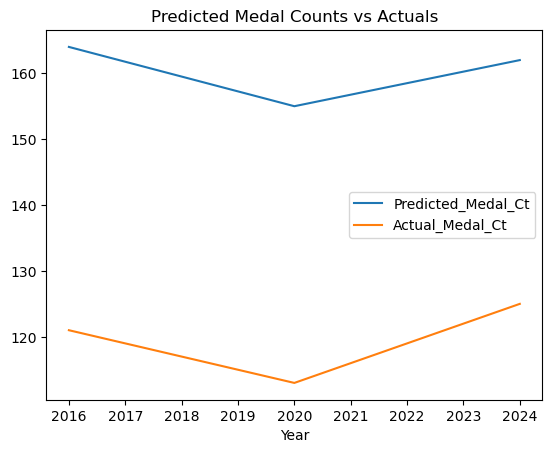

In [65]:
#plot results 
actual_pred_plot = actual_predictions_df.set_index('Year')
actual_pred_plot[['Predicted_Medal_Ct','Actual_Medal_Ct']].plot(title='Predicted Medal Counts vs Actuals')

In [74]:
# Get medal count by country - top 5
top_five = df.groupby('Country').agg(Medal_count=('Medal', 'count')).sort_values('Medal_count', ascending=False).reset_index()
top_five.head()

,Country,Medal_count
0,USA,4585
1,URS,2049
2,GBR,1720
3,FRA,1396
4,GER,1305


In [75]:
# Get medal count by year, country 
medal_ct_country = df.groupby(['Year', 'Country']).agg(Medal_count=('Medal', 'count')).sort_values('Medal_count', ascending=False).reset_index()

In [76]:
# Get medal count by year, country, medal groupings
medal_type_ct_country = df.groupby(['Year', 'Country', 'Medal']).agg(Medal_count=('Medal', 'count')).sort_values('Medal_count', ascending=False).reset_index()

In [77]:
# Select countries in second and third place (URS and GBR) and set year as index
urs_df = medal_ct_country.loc[medal_ct_country['Country'] == 'URS'].sort_values(by=['Year'])
urs_df.set_index('Year', inplace=True)
gbr_df = medal_ct_country.loc[medal_ct_country['Country'] == 'GBR'].sort_values(by=['Year'])
gbr_df.set_index('Year', inplace=True)

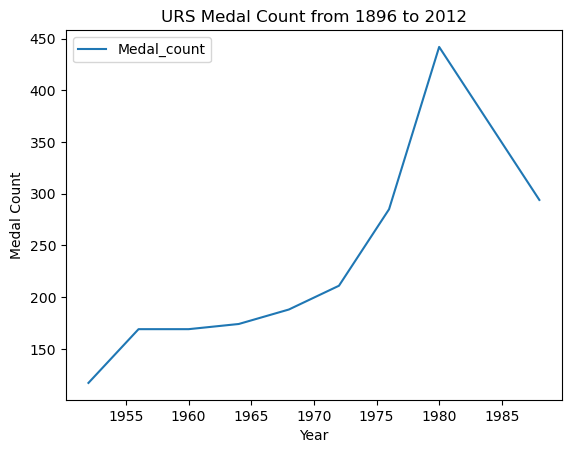

In [78]:
# Plot the dataframes for URS and GBR
urs_df.plot(title='URS Medal Count from 1896 to 2012')
plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.show()

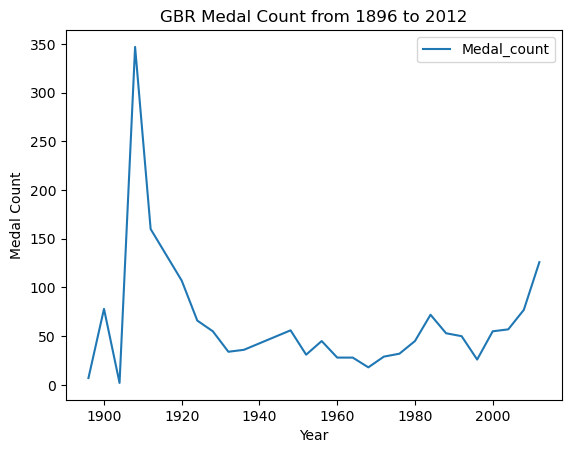

In [79]:
gbr_df.plot(title='GBR Medal Count from 1896 to 2012')
plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.show()


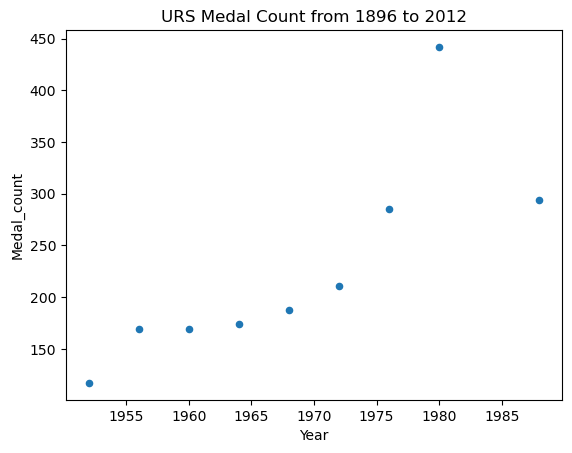

In [80]:
# Create scatter plots for URS and GBR medal counts over the years
urs_df.reset_index(inplace=True)
urs_plot = urs_df.plot.scatter(x='Year', y='Medal_count', title='URS Medal Count from 1896 to 2012')
plt.show()

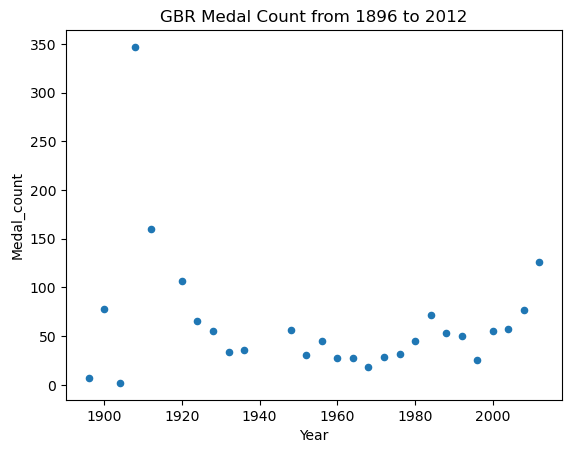

In [81]:
gbr_df.reset_index(inplace=True)
gbr_plot = gbr_df.plot.scatter(x='Year', y='Medal_count', title='GBR Medal Count from 1896 to 2012')
plt.show()

In [93]:
# Time Series Forecasting Projections Using Prophet for URS
# Drop the country column for URS
prophet_df_urs = urs_df.drop('Country', axis=1)
# Convert year to datetime
prophet_df_urs['Year'] = pd.to_datetime(prophet_df_urs['Year'], format='%Y')
# Prepare the training data to be read into a prophet model
# Rename the columns to names that Prophet recognizes
prophet_df_urs.columns = ['ds', 'y']
prophet_df_urs.head()

,ds,y
0,1952-01-01,117
1,1956-01-01,169
2,1960-01-01,169
3,1964-01-01,174
4,1968-01-01,188


In [83]:
# Confirm that there are no NaN values
prophet_df_urs = prophet_df_urs.dropna()
prophet_df_urs.tail()

,ds,y
4,1968-01-01,188
5,1972-01-01,211
6,1976-01-01,285
7,1980-01-01,442
8,1988-01-01,294


In [84]:
# Call the Prophet function and store as an object
m_urs = Prophet()
# Fit the time series Prophet model
m_urs.fit(prophet_df_urs)

09:24:54 - cmdstanpy - INFO - Chain [1] start processing
09:24:54 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
# Create a future DataFrame to hold predictions
future_urs = m_urs.make_future_dataframe(periods=13, freq='Y')

C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [86]:
# Review the first and last 10 rows of the DataFrame
future_urs.tail(13)

,ds
9,1988-12-31
10,1989-12-31
11,1990-12-31
12,1991-12-31
13,1992-12-31
14,1993-12-31
15,1994-12-31
16,1995-12-31
17,1996-12-31
18,1997-12-31


In [87]:
# Make a forecast based on the future DataFrame
forecast_urs = m_urs.predict(future_urs)

In [88]:
# Review the first five rows of the forecast DataFrame
display(forecast_urs.head())
display(forecast_urs.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1952-01-01,2.876669,43.592100,189.343629,2.876669,2.876669,113.735134,113.735134,113.735134,113.735134,113.735134,113.735134,0.0,0.0,0.0,116.611803
1,1956-01-01,29.893722,73.572581,216.780901,29.893722,29.893722,113.735134,113.735134,113.735134,113.735134,113.735134,113.735134,0.0,0.0,0.0,143.628856
2,1960-01-01,56.910776,92.995591,239.522498,56.910776,56.910776,113.735134,113.735134,113.735134,113.735134,113.735134,113.735134,0.0,0.0,0.0,170.645910
3,1964-01-01,83.927829,128.390944,269.546701,83.927829,83.927829,113.735134,113.735134,113.735134,113.735134,113.735134,113.735134,0.0,0.0,0.0,197.662963
4,1968-01-01,110.944883,160.107479,297.254842,110.944883,110.944883,113.735134,113.735134,113.735134,113.735134,113.735134,113.735134,0.0,0.0,0.0,224.680017


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
17,1996-12-31,306.813898,352.643103,489.767006,306.813897,306.813899,113.694645,113.694645,113.694645,113.694645,113.694645,113.694645,0.0,0.0,0.0,420.508543
18,1997-12-31,313.563538,354.873442,504.812258,313.563537,313.563540,113.573226,113.573226,113.573226,113.573226,113.573226,113.573226,0.0,0.0,0.0,427.136764
19,1998-12-31,320.313179,363.180140,506.819967,320.313177,320.313180,113.371026,113.371026,113.371026,113.371026,113.371026,113.371026,0.0,0.0,0.0,433.684204
20,1999-12-31,327.062819,369.355656,511.775664,327.062817,327.062821,113.088289,113.088289,113.088289,113.088289,113.088289,113.088289,0.0,0.0,0.0,440.151108
21,2000-12-31,333.830951,376.076703,517.452502,333.830949,333.830954,113.694645,113.694645,113.694645,113.694645,113.694645,113.694645,0.0,0.0,0.0,447.525596


In [113]:
# Find the closest date to '2024-12-31' in the forecast DataFrame
forecast_urs['ds'] = pd.to_datetime(forecast_urs['ds'])
closest_date_urs = forecast_urs.iloc[(forecast_urs['ds'] - pd.Timestamp('2024-12-31')).abs().argsort()[:1]]

In [114]:
# Extract the total predicted medal count for the closest date to 2024 for URS
urs_2024_medal_count = closest_date_urs['yhat'].values[0]
print(f'Predicted medal count for URS in 2024: {urs_2024_medal_count:.2f}')

Predicted medal count for URS in 2024: 447.53


C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


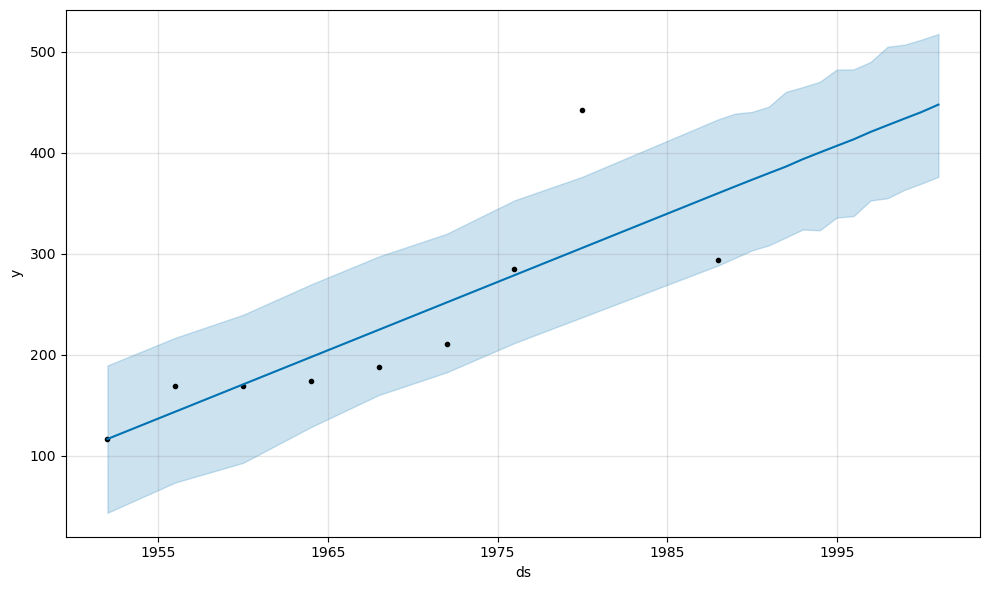

In [89]:
# Plot the forecast using the model’s plot function
m_urs.plot(forecast_urs)
plt.show()

C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

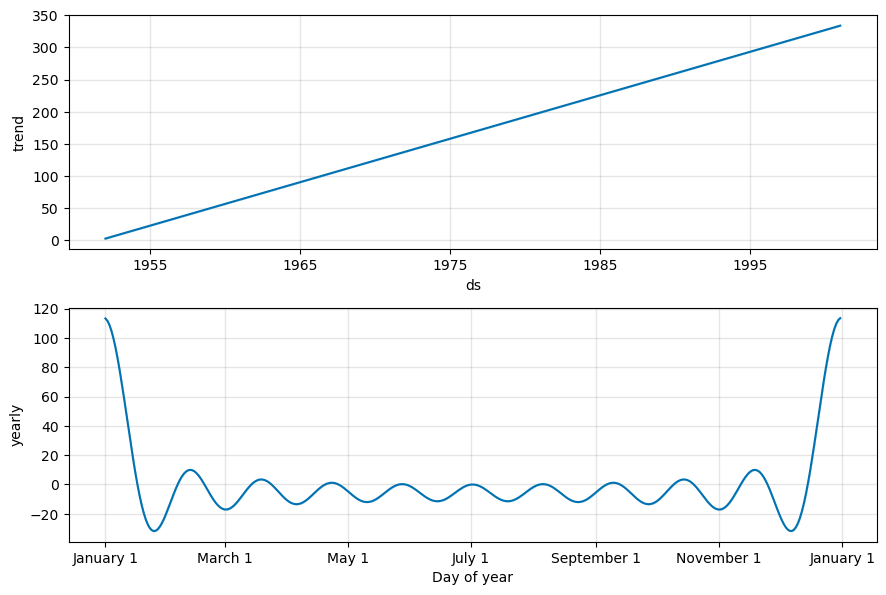

In [90]:
# Plot the individual time series components of the model
fig2_urs = m_urs.plot_components(forecast_urs)
plt.show()

In [94]:
# Perform cross-validation for URS
df_cv_urs = cross_validation(m_urs, initial='3650 days', period='365 days', horizon='730 days')


  0%|          | 0/6 [00:00<?, ?it/s]

09:28:28 - cmdstanpy - INFO - Chain [1] start processing
09:28:28 - cmdstanpy - INFO - Chain [1] done processing
09:28:28 - cmdstanpy - INFO - Chain [1] start processing
09:28:28 - cmdstanpy - INFO - Chain [1] done processing
09:28:28 - cmdstanpy - INFO - Chain [1] start processing
09:28:28 - cmdstanpy - INFO - Chain [1] done processing
09:28:28 - cmdstanpy - INFO - Chain [1] start processing
09:28:29 - cmdstanpy - INFO - Chain [1] done processing
09:28:29 - cmdstanpy - INFO - Chain [1] start processing
09:28:29 - cmdstanpy - INFO - Chain [1] done processing
09:28:29 - cmdstanpy - INFO - Chain [1] start processing
09:28:29 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
# Calculate performance metrics for URS
df_metrics_urs = performance_metrics(df_cv_urs)

In [97]:
# Calculate MAE, MSE, and RMSE for URS
mae_urs = mean_absolute_error(df_cv_urs['y'], df_cv_urs['yhat'])
mse_urs = mean_squared_error(df_cv_urs['y'], df_cv_urs['yhat'])
rmse_urs = np.sqrt(mse_urs)
print(f'URS - Mean Absolute Error: {mae_urs:.2f}')
print(f'URS - Mean Squared Error: {mse_urs:.2f}')
print(f'URS - Root Mean Squared Error: {rmse_urs:.2f}')

URS - Mean Absolute Error: 65.77
URS - Mean Squared Error: 7920.32
URS - Root Mean Squared Error: 89.00


In [98]:
# Time Series Forecasting Projections Using Prophet for GBR
# Drop the country column for GBR
prophet_df_gbr = gbr_df.drop('Country', axis=1)
# Convert year to datetime
prophet_df_gbr['Year'] = pd.to_datetime(prophet_df_gbr['Year'], format='%Y')
# Prepare the training data to be read into a prophet model
# Rename the columns to names that Prophet recognizes
prophet_df_gbr.columns = ['ds', 'y']
prophet_df_gbr.head()

,ds,y
0,1896-01-01,7
1,1900-01-01,78
2,1904-01-01,2
3,1908-01-01,347
4,1912-01-01,160


In [99]:
# Confirm that there are no NaN values
prophet_df_gbr = prophet_df_gbr.dropna()
prophet_df_gbr.tail()

,ds,y
22,1996-01-01,26
23,2000-01-01,55
24,2004-01-01,57
25,2008-01-01,77
26,2012-01-01,126


In [100]:
# Call the Prophet function and store as an object
m_gbr = Prophet()

In [101]:
# Fit the time series Prophet model
m_gbr.fit(prophet_df_gbr)

11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
# Create a future DataFrame to hold predictions
future_gbr = m_gbr.make_future_dataframe(periods=13, freq='Y')

C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [103]:
# Review the first and last 10 rows of the DataFrame
future_gbr.tail(13)

,ds
27,2012-12-31
28,2013-12-31
29,2014-12-31
30,2015-12-31
31,2016-12-31
32,2017-12-31
33,2018-12-31
34,2019-12-31
35,2020-12-31
36,2021-12-31


In [104]:
# Make a forecast based on the future DataFrame
forecast_gbr = m_gbr.predict(future_gbr)

In [105]:
# Review the first five rows of the forecast DataFrame
display(forecast_gbr.head())
display(forecast_gbr.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1896-01-01,1.806066,-37.630053,120.402380,1.806066,1.806066,41.966777,41.966777,41.966777,41.966777,41.966777,41.966777,0.0,0.0,0.0,43.772843
1,1900-01-01,-0.566250,-32.762139,119.698048,-0.566250,-0.566250,41.966777,41.966777,41.966777,41.966777,41.966777,41.966777,0.0,0.0,0.0,41.400527
2,1904-01-01,-2.936942,15.994314,178.932289,-2.936942,-2.936942,102.111399,102.111399,102.111399,102.111399,102.111399,102.111399,0.0,0.0,0.0,99.174457
3,1908-01-01,-5.309257,15.077091,179.048559,-5.309257,-5.309257,102.111399,102.111399,102.111399,102.111399,102.111399,102.111399,0.0,0.0,0.0,96.802142
4,1912-01-01,-7.681573,12.000067,171.186493,-7.681573,-7.681573,102.111399,102.111399,102.111399,102.111399,102.111399,102.111399,0.0,0.0,0.0,94.429826


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
35,2020-12-31,-72.326764,-32.020637,128.381206,-72.326764,-72.326763,116.973695,116.973695,116.973695,116.973695,116.973695,116.973695,0.0,0.0,0.0,44.646931
36,2021-12-31,-72.919436,-18.409056,139.840668,-72.919437,-72.919436,131.730152,131.730152,131.730152,131.730152,131.730152,131.730152,0.0,0.0,0.0,58.810715
37,2022-12-31,-73.512109,-4.089255,156.112721,-73.512110,-73.512109,146.362842,146.362842,146.362842,146.362842,146.362842,146.362842,0.0,0.0,0.0,72.850733
38,2023-12-31,-74.104782,1.782130,165.431268,-74.104783,-74.104782,160.854004,160.854004,160.854004,160.854004,160.854004,160.854004,0.0,0.0,0.0,86.749222
39,2024-12-31,-74.699079,-36.996773,120.331335,-74.699080,-74.699078,116.973695,116.973695,116.973695,116.973695,116.973695,116.973695,0.0,0.0,0.0,42.274616


In [112]:
# Extract the total predicted medal count for 2024 for GBR
gbr_2024_medal_count = forecast_gbr.loc[forecast_gbr['ds'] == '2024-12-31', 'yhat'].values[0]
print(f'Predicted medal count for GBR in 2024: {gbr_2024_medal_count:.2f}')


Predicted medal count for GBR in 2024: 42.27


C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


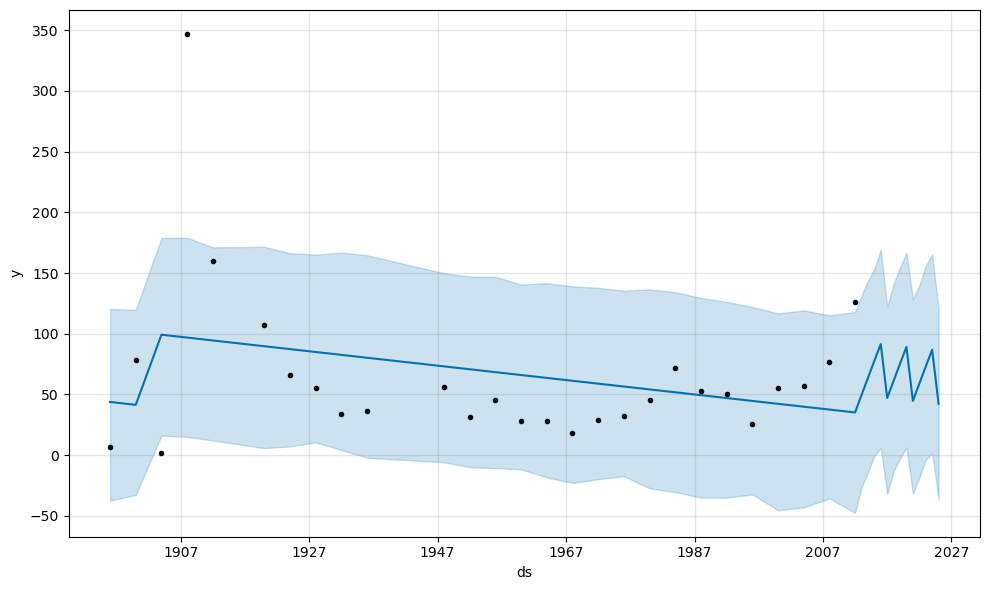

In [106]:
# Plot the forecast using the model’s plot function
m_gbr.plot(forecast_gbr)
plt.show()

C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\sebas\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

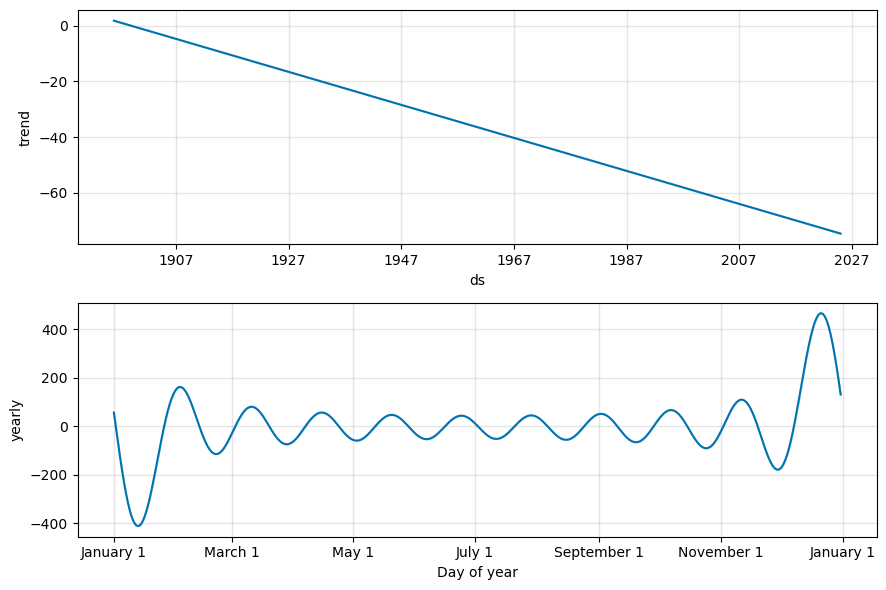

In [107]:
# Plot the individual time series components of the model
fig2_gbr = m_gbr.plot_components(forecast_gbr)
plt.show()

In [108]:
# Perform cross-validation for GBR
df_cv_gbr = cross_validation(m_gbr, initial='3650 days', period='365 days', horizon='730 days')

  0%|          | 0/24 [00:00<?, ?it/s]

11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:35 - cmdstanpy - INFO - Chain [1] done processing
11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1]

In [109]:
# Calculate performance metrics for GBR
df_metrics_gbr = performance_metrics(df_cv_gbr)

In [110]:
# Calculate MAE, MSE, and RMSE for GBR
mae_gbr = mean_absolute_error(df_cv_gbr['y'], df_cv_gbr['yhat'])
mse_gbr = mean_squared_error(df_cv_gbr['y'], df_cv_gbr['yhat'])
rmse_gbr = np.sqrt(mse_gbr)

print(f'GBR - Mean Absolute Error: {mae_gbr:.2f}')
print(f'GBR - Mean Squared Error: {mse_gbr:.2f}')
print(f'GBR - Root Mean Squared Error: {rmse_gbr:.2f}')

GBR - Mean Absolute Error: 76.15
GBR - Mean Squared Error: 13345.95
GBR - Root Mean Squared Error: 115.52


# Calculate the medal breakdown (Gold,Silver,Bronze)

In [115]:
# Calculate historical proportions of Gold, Silver, and Bronze medals for each country
def calculate_medal_proportions(country, df):
    country_df = df[df['Country'] == country]
    medal_counts = country_df['Medal'].value_counts(normalize=True)
    return medal_counts.get('Gold', 0), medal_counts.get('Silver', 0), medal_counts.get('Bronze', 0)


In [116]:
# Apply the historical proportions to the total predicted medal count
def predict_medal_breakdown(total_medals, proportions):
    gold_proportion, silver_proportion, bronze_proportion = proportions
    gold_count = total_medals * gold_proportion
    silver_count = total_medals * silver_proportion
    bronze_count = total_medals * bronze_proportion
    return gold_count, silver_count, bronze_count

In [117]:
# Calculate historical proportions
usa_proportions = calculate_medal_proportions('USA', df)
urs_proportions = calculate_medal_proportions('URS', df)
gbr_proportions = calculate_medal_proportions('GBR', df)

In [118]:
# Predicted total medals for 2024
usa_total_predicted = 279.70
urs_total_predicted = 234.61
gbr_total_predicted = 160.79

In [119]:
# Predict breakdown for each country
usa_gold, usa_silver, usa_bronze = predict_medal_breakdown(usa_total_predicted, usa_proportions)
urs_gold, urs_silver, urs_bronze = predict_medal_breakdown(urs_total_predicted, urs_proportions)
gbr_gold, gbr_silver, gbr_bronze = predict_medal_breakdown(gbr_total_predicted, gbr_proportions)

print(f"USA Predicted Medals for 2024: Gold: {usa_gold:.2f}, Silver: {usa_silver:.2f}, Bronze: {usa_bronze:.2f}")
print(f"URS Predicted Medals for 2024: Gold: {urs_gold:.2f}, Silver: {urs_silver:.2f}, Bronze: {urs_bronze:.2f}")
print(f"GBR Predicted Medals for 2024: Gold: {gbr_gold:.2f}, Silver: {gbr_silver:.2f}, Bronze: {gbr_bronze:.2f}")

USA Predicted Medals for 2024: Gold: 136.34, Silver: 76.38, Bronze: 66.98
URS Predicted Medals for 2024: Gold: 95.95, Silver: 71.79, Bronze: 66.87
GBR Predicted Medals for 2024: Gold: 51.04, Silver: 58.05, Bronze: 51.70
